In [1]:
from pathlib import Path
import yaml
import numpy as np
from torch.utils.data import DataLoader

from torchvision.models import resnet18
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from torch.nn import BCEWithLogitsLoss
from torch.utils.data import random_split, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint

from sklearn.metrics import roc_curve, auc, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from omegaconf import OmegaConf
from hydra.utils import instantiate

import os
import torch
import sys
import pickle

sys.path.append("/home/erogullari/Workspace/cav-disentanglement")

In [2]:
from utils.cav import compute_cavs

def get_baseline_cavs(model_name:str, layer:str, dataset_name:str, cav_type:str) -> torch.Tensor:
    base_path = Path("/home/erogullari/Workspace/cav-disentanglement/variables")
    vars_path = base_path / dataset_name / f"{model_name}" / f"{layer}.pth"
    vars = torch.load(vars_path, map_location="cpu", weights_only=True)
    encs = vars['encs']
    labels = vars['labels']
    cavs, _ = compute_cavs(encs, labels, type=cav_type, normalize=True)
    return cavs

## AUC vs Orthogonality over Epochs

In [6]:
save_dir = Path("/home/erogullari/Workspace/cav-disentanglement/results/cav_disentanglement")
out_dir = Path("/home/erogullari/Workspace/cav-disentanglement/media/cav_disentanglement")
save_dirs = {
    "celeba": save_dir / "celeba" / "vgg16_features.28",
    "elements": save_dir / "elements" / "simplenet_features.30"
}

In [43]:
def visualize_auc_vs_orthogonality(exp_dir, title="", out_path=None):
    with open(exp_dir / "metrics/auc_hist.pkl", 'rb') as f:
        cav_performance_history = np.array(pickle.load(f)).mean(axis=1)
    with open(exp_dir / "metrics/uniqueness_hist.pkl", 'rb') as f:
        cav_uniqueness_history = np.array(pickle.load(f)).mean(axis=1)

    epochs_logged = list(range(0, 10 * len(cav_performance_history), 10))
    fig, ax1 = plt.subplots(figsize=(10, 6))
    palette = sns.color_palette("tab10")
    color1 = palette[0]
    color2 = palette[3]

    # Left y-axis: AUROC
    line1, = ax1.plot(
        epochs_logged,
        cav_performance_history,
        linestyle='-',
        color=color1,
        label='AUROC'
    )
    ax1.set_ylabel('AUROC', color=line1.get_color())
    ax1.set_ylim(0.49, 1.01)
    ax1.tick_params(axis='y', labelcolor=line1.get_color())

    # Right y-axis: Orthogonality
    ax2 = ax1.twinx()
    line2, = ax2.plot(
        epochs_logged,
        cav_uniqueness_history,
        linestyle='-',
        color=color2,
        label='Orthogonality'
    )
    ax2.set_ylabel('Orthogonality', color=line2.get_color())
    ax2.tick_params(axis='y', labelcolor=line2.get_color())

    ax1.set_xlabel('Epochs')
    ax1.set_title(title)
    ax1.grid(True)

    # Combined legend
    lines = [line1, line2]
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='best')

    if out_path:
        plt.savefig(out_path, dpi=300, bbox_inches='tight', format="pdf")
        plt.close()

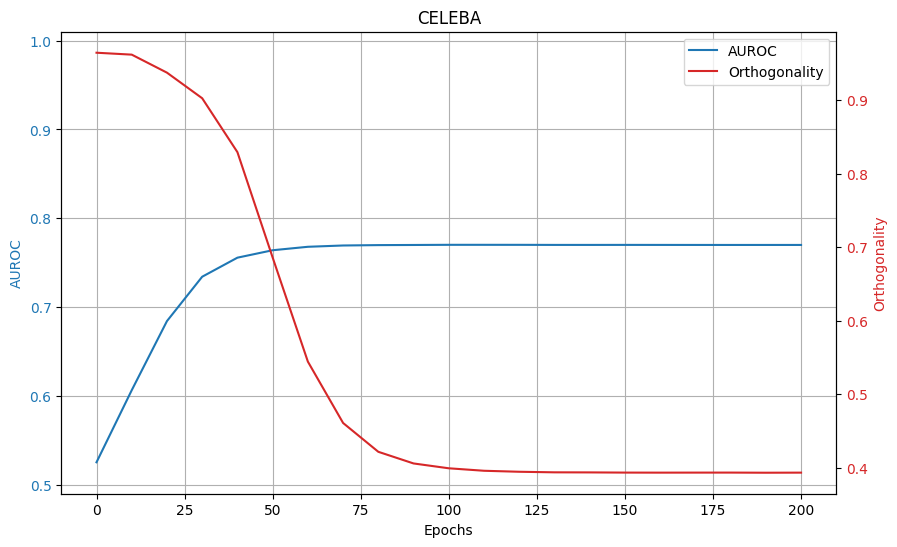

In [44]:
dataset = "celeba"
cav_type = "pattern_cav"
alpha = "0"
lr = "0.0001"

exp_dir = save_dirs[dataset] / f"{cav_type}/alpha{alpha}_lr{lr}"
out_path = out_dir / dataset / f"{cav_type}_alpha{alpha}_lr{lr}_auc_orthogonality.pdf"
visualize_auc_vs_orthogonality(exp_dir, title=dataset.upper(), out_path=None)

## Main Figure Heatmaps

In [9]:
from torch import nn
import torchvision.transforms as T
from typing import List
from crp.attribution import CondAttribution
from zennit.canonizers import Canonizer
from zennit.composites import EpsilonPlusFlat
from zennit.torchvision import ResNetCanonizer, VGGCanonizer
from crp.image import imgify
from experiments.utils.activations import _get_features, extract_latents
from experiments.utils.localization import get_localization
from utils.visualizations import visualize_heatmaps, visualize_heatmap_pair



In [4]:
from datasets import get_celeba_dataset
from models import get_vgg16

result_dir = Path("/home/erogullari/Workspace/cav-disentanglement/results/cav_disentanglement/celeba/vgg16_features.28")
out_dir = Path("/home/erogullari/Workspace/cav-disentanglement/media/cav_disentanglement")
ckpt_path = Path("/media/erogullari/checkpoints/checkpoint_vgg16_celeba.pth")
data_path = Path("/home/erogullari/datasets/")

model = get_vgg16(ckpt_path, n_class=2).to("cpu")
dataset = get_celeba_dataset([data_path], normalize_data=True, image_size=128)

Number of samples with mustache and necktie:  1692
108


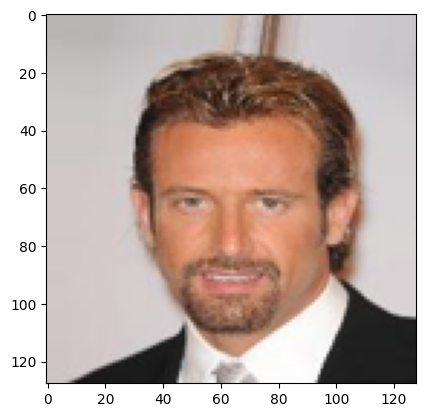

208


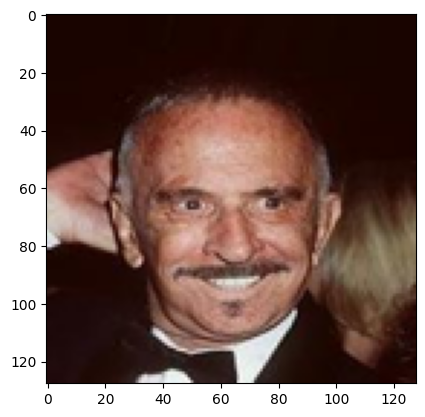

451


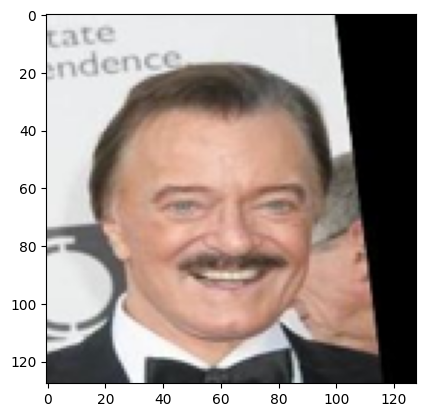

536


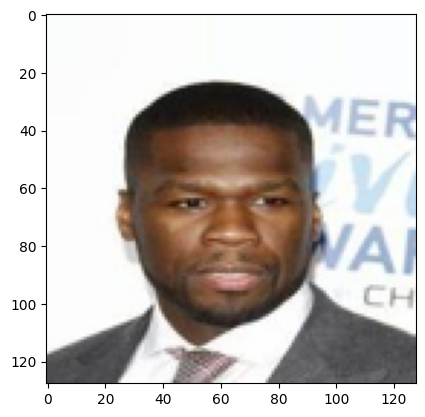

660


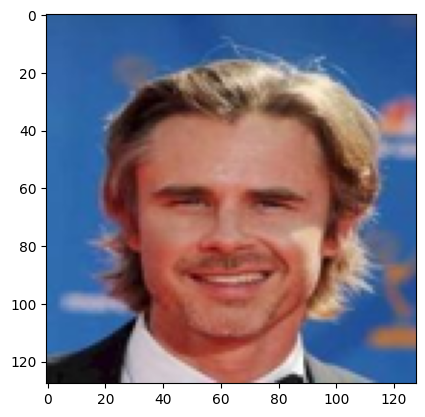

In [7]:
concept_names = dataset.get_concept_names()
mustache_idx = concept_names.index("Mustache")
necktie_idx = concept_names.index("Wearing_Necktie")

# First locate rows in dataset.attributes where mustache and necktie are present
targets = dataset.attributes.loc[
    (dataset.attributes["Mustache"] == 1) & (dataset.attributes["Wearing_Necktie"] == 1)
].index.tolist()
print("Number of samples with mustache and necktie: ", len(targets))
start = 0

for img_id in targets[start:start + 5]:
    print(img_id)
    x, y = dataset[img_id]
    img = dataset.reverse_normalization(x).permute(1, 2, 0).numpy()
    plt.imshow(img)
    plt.show()

In [ ]:
cav_type = "pattern_cav"
alpha = "0.1"
lr = "0.0001"

cav_path = result_dir / cav_type / f"alpha{alpha}_lr{lr}_opt" / "cavs.pt"
cavs_orth = torch.load(cav_path, map_location="cpu")
cavs_baseline = get_baseline_cavs("vgg16", "features.28", "celeba", cav_type)



(torch.Size([40, 512]), torch.Size([40, 512]))

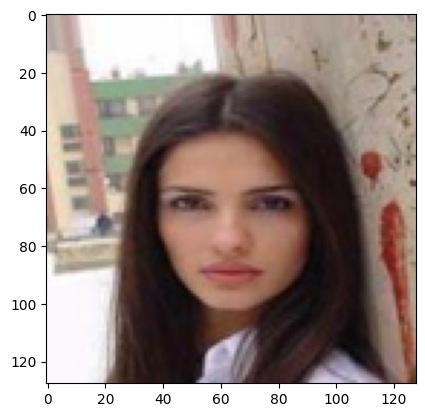

In [ ]:


def visualize_heatmaps(img: torch.Tensor, heatmaps: List[torch.Tensor], out_path: Path | None=None):
    """Visualize and save heatmaps for two concepts using both baseline and orthogonal CAVs. """



def localize_and_visualize(img: torch.Tensor, model: nn.Module, layer: str, cav_orth: torch.Tensor, cav_baseline: torch.Tensor, concept_idxs: List[int], device: str, out_dir: Path | None = None):
    canonizers: List[Canonizer] = [VGGCanonizer()]
    attribution = CondAttribution(model)
    cav1_orth = cav_orth[concept_idxs[0]]
    cav2_orth = cav_orth[concept_idxs[1]]
    cav1_baseline = cav_baseline[concept_idxs[0]]
    cav2_baseline = cav_baseline[concept_idxs[1]]

    x = img.unsqueeze(0)
    heatmap1_orth = get_localization(
        x, model, layer, cav1_orth, attribution, canonizers, cav_mode="max", device=device
    )
    heatmap2_orth = get_localization(
        x, model, layer, cav2_orth, attribution, canonizers, cav_mode="max", device=device  
    )
    heatmap_baseline1 = get_localization(
        x, model, layer, cav1_baseline, attribution, canonizers, cav_mode="max", device=device
    )
    heatmap_baseline2 = get_localization(
        x, model, layer, cav2_baseline, attribution, canonizers, cav_mode="max", device=device
    )

    visualize_heatmaps()
    